<a href="https://colab.research.google.com/github/jakey1610/MachineLearningL3/blob/master/notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Define the Discriminatory Network model**

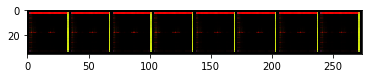

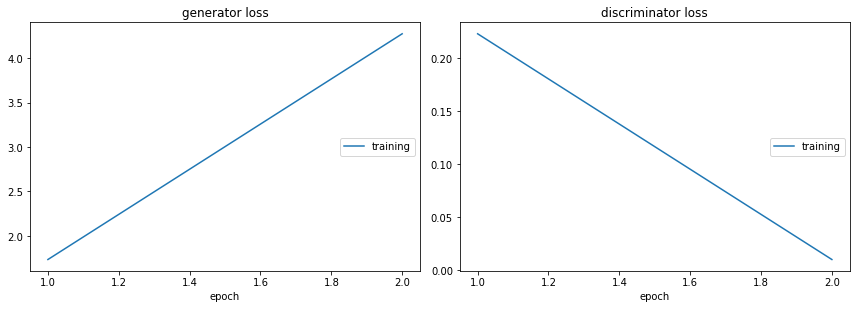

generator loss:
training   (min:    1.734, max:    4.275, cur:    4.275)

discriminator loss:
training   (min:    0.010, max:    0.223, cur:    0.010)


KeyboardInterrupt: ignored

In [0]:
# training loop
while (epoch<50):
    
    # arrays for metrics
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(100):
        # train discriminator 
        for j in range(5):
            x,t = next(test_iterator)
            x,t = x.to(device), t.to(device)
            optimiser_D.zero_grad()
            g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
            l_r = bce_loss(DN.discriminate(x).mean(), torch.ones(1)[0].to(device)) # real -> 1
            l_f = bce_loss(DN.discriminate(g.detach()).mean(), torch.zeros(1)[0].to(device)) #  fake -> 0
            loss_d = (l_r + l_f)/2.0
            loss_d.backward()
            optimiser_D.step()
          
        # train generator
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        optimiser_G.zero_grad()
        g = GN.generate(torch.randn(x.size(0), 100, 1, 1).to(device))
        loss_g = bce_loss(DN.discriminate(g).mean(), torch.ones(1)[0].to(device)) # fake -> 1
        loss_g.backward()
        optimiser_G.step()

        gen_loss_arr = np.append(gen_loss_arr, loss_g.item())
        dis_loss_arr = np.append(dis_loss_arr, loss_d.item())

    # plot some examples
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    liveplot.update({
        'generator loss': gen_loss_arr.mean(),
        'discriminator loss': dis_loss_arr.mean()
    })
    liveplot.draw()
    epoch = epoch+1

In [0]:
# define the discriminatory model
class DiscNet(nn.Module):
    def __init__(self):
        super(DiscNet, self).__init__()
        layers = nn.ModuleList()
        conv1 = nn.Sequential(nn.Conv2d(3,128,4,stride=2,padding=1,bias=False),nn.LeakyReLU(0.2,in_place=True))
        layers.append(conv1)
        conv2 = nn.Sequential(nn.Conv2d(128,256,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(256),nn.LeakyReLU(0.2))
        layers.append(conv2)
        conv3 = nn.Sequential(nn.Conv2d(265,512,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(512),nn.LeakyReLU(0.2))
        layers.append(conv3)
        conv4 = nn.Sequential(nn.Conv2d(512,1024,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(1024),nn.LeakyReLU(0.2))
        layers.append(conv4)
        dec = nn.Sequential(nn.Linear(1024*4*4,3),nn.Sigmoid())
        layers.append(dec)
        self.layers = layers

    def forward(self, x):
        x = self.encode(x)
        return x

    def encode(self, x):
        for i in range(4):
            x = self.layers[i](x)
        x = x.view(-1,1024*4*4)
        x = self.layers[4](x)
        return x

print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

> Number of network parameters 11142659


**Define the Generative Network**

In [0]:
class GenNet(nn.Module):
  def __init__(self):
    super(GenNet,self).__init__()
    layers = nn.ModuleList()
    linear = nn.Linear(100,1024*4*4)
    layers.append(linear)
    conv1 = nn.Sequential(nn.ConvTranspose2d(1024,512,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(512),nn.ReLU(inplace=True))
    layers.append(conv1)
    conv2 = nn.Sequential(nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(256),nn.ReLU(inplace=True))
    layers.append(conv2)
    conv3 = nn.Sequential(nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),nn.BatchNorm2d(128),nn.ReLU(inplace=True))
    layers.append(conv3)
    conv4 = nn.Sequential(nn.ConvTranspose2d(128,1,4,stride=2,padding=1,bias=False))
    layers.append(conv4)
    dec = nn.Tanh()
    layers.append(dec)
    self.layers = layers
    
  def forward(self,x):
    x = self.layers[0](x)
    x = x.view(x.shape[0],1024,4,4)
    for i in range(4):
      x = self.layers[i+1](x)
    return self.layers[-1](x)
